In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

# miRNA Target Discovery via CLIP-SEQ

In [2]:
import json
import pandas as pd
import numpy as np
import pybedtools
import requests
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import time
from urllib.parse import urlparse
from IPython.display import Markdown, display

from matplotlib.ticker import MaxNLocator

In [3]:
%%appyter hide_code

{% do SectionField(
    name='DCLIP',
    title='1. Upload dCLIP output',
    subtitle='Upload results from running dCLIP (https://qbrc.swmed.edu/softwares.php).',
    img='tilde.png'    
) %}

{% do SectionField(
    name='GENOME',
    title='2. Choose the genome',
    subtitle='Choose the genome used for your study, you can also upload custom bed files',
    img='dna.png'
    
) %}

{% do SectionField(
    name='ENRICHMENT',
    title='3. Choose Enrichr Libraries for Enrichment',
    subtitle='Choose libraries to use for enrichment',
    img='enrichr.png'
    
) %}

In [4]:
# helper functions
def is_url(text):
    try:
        result = urlparse(text)
        return all([result.scheme, result.netloc])
    except:
        return False

## Load input

In [5]:
%%appyter code_exec

{% set dCLIP_experiment = ChoiceField(name='dCLIP experiment',
                                  description='Condition for dCLIP',
                                  label='type of experiment',
                                  section="DCLIP",
                                  choices=['Perturbation v Negative Control', 'Perturbation v Positive Control'],
                                  default='Perturbation v Negative Control').safe_value %}

{% set dCLIP_output_file = FileField(
    name='dclip_output_filename',
    label='dclip output (dCLIP_output.txt)',
    default='GSE137071_output.txt',
    section="DCLIP",
    examples={
        'GSE137071_output.txt': 'https://appyterbucket.s3.amazonaws.com/sample_data/dCLIP_output.txt'
    }
) %}

{% set dCLIP_summary_file = FileField(
    name='dclip_summary_filename',
    label='dclip output (dCLIP_summary.bed)',
    default='GSE137071_summary.bed',
    section="DCLIP",
    description='Upload dCLIP_summary.bed',
    examples={
        'GSE137071_summary.bed': 'https://appyterbucket.s3.amazonaws.com/sample_data/dCLIP_summary.bed'
    }
) %}

dCLIP_experiment = "{{ dCLIP_experiment }}"
dCLIP_output_file = {{ dCLIP_output_file }}
dCLIP_summary_file = {{ dCLIP_summary_file }}

```python
dCLIP_experiment = "Perturbation v Negative Control"
dCLIP_output_file = 'GSE137071_output.txt'
dCLIP_summary_file = 'GSE137071_summary.bed'
```

### dCLIP output
`dCLIP_output.txt` is a tab separated file that contains information on differential binding of the samples. this is written in the state column.

**state column**:

0 refers to a bin with more binding in condition 2 than condition 1 <br>
1 refers to a bin with equal binding in both conditions <br>
2 refers to a bin with more binding in condition 1 than condition 2

In [6]:
dclip_output = pd.read_csv(dCLIP_output_file, sep="\t")
dclip_output.head()

id chrom strand  position  state  probability  differential  tag1  mut1  \
0   1  chr7      -    152085      1     0.998338     -0.095310     0     0   
1   1  chr7      -    152090      1     0.684900     -0.470004     0     0   
2   1  chr7      -    152095      0     0.705606     -0.693147     0     0   
3   1  chr7      -    152100      0     0.907399     -0.788457     0     0   
4   1  chr7      -    152105      0     0.979348     -0.916291     0     0   

   tag2  mut2  
0     1     0  
1     6     0  
2    10     0  
3    12     0  
4    15     0

**Table 1** dClip Output

### dCLIP_summary.bed

`dCLIP_summay.bed` contains the summary of the inference results. We note the following columns:

**Column 3**: Cluster id <br>
**Column 4**: "The fifth column is the average binding strength of condition 1 in this continuous region if in state 2, the average binding strength of condition 2 if in state 0 and 0 if in state 1"

In [7]:
dCLIP_summary = pybedtools.BedTool(dCLIP_summary_file)    
dCLIP_summary.head()

track name="dCLIP_summary" description="dCLIP_summary" itemRgb="On"
 chr7	152085	152094	1	0	-	152085	152094	0,255,0
 chr7	152095	152164	1	2	-	152095	152164	255,0,0
 chr7	152165	152234	1	0	-	152165	152234	0,255,0
 chrUn	250	314	2	0	-	250	314	0,255,0
 chrUn	315	404	3	2	-	315	404	0,0,255
 chrUn	405	419	3	0	-	405	419	0,255,0
 chrUn	1160	1324	4	0	-	1160	1324	0,255,0
 chr5	119685	119719	5	5	+	119685	119719	0,0,255
 chr5	163385	163414	6	4	+	163385	163414	255,0,0
 

#### Number of clusters

In [8]:
len(dclip_output.id.unique())

121118

In [9]:
dclip_output["pos_concat"] = dclip_output.id.astype(str) + dclip_output.chrom.astype(str) + dclip_output.position.astype(str)

In [10]:
%%appyter code_exec
top_ranked = {{IntField(name='TopGenes', label='Top Genes', min=50, max=1000, default=500, section='DCLIP')}}

```python

top_ranked = 500
```

## Genome files
We load the bed files for the whole genes and 3' UTR as well as the gene name mapper

In [11]:
%%appyter code_exec
genome_type = "{{ ChoiceField(name='Genome',description='Name of Genome',label='Genome',choices=['UCSC human (hg38)', 'UCSC mouse (mm10)', 'custom'],default='UCSC human (hg38)',section='GENOME').safe_value }}"

whole_gene_bed_file = "{{ FileField(name='whole_gene_bed_filename',label='Custom Whole Gene Bed File (Optional)',default='',description='Bed file for whole genes',section='GENOME').value }}"

utr_gene_bed_file = "{{ FileField(name='utr_gene_bed_filename',label='3 UTR Bed File (Optional)',default='',description='Custom Bed file for 3 UTR',section='GENOME').value }}"

gene_name_map_file = "{{ FileField(name='gene_name_map_file',label='Gene Mapping File (Optional)',default='',description='Custom Gene name mapper (Optional)',section='GENOME').value }}"

```python
genome_type = "UCSC human (hg38)"
whole_gene_bed_file = ""
utr_gene_bed_file = ""
gene_name_map_file = ""
```

In [12]:
if not genome_type == "custom":
    whole_gene_bed_file = "wholegenes.bed"
    utr_gene_bed_file = "3UTR.bed"
    gene_name_map_file = "gene_name.tsv"
    if genome_type == "UCSC mouse (mm10)":
        whole_gene_bed_url = "https://appyterbucket.s3.amazonaws.com/mm10/mm10.wholegenes.bed"
        utr_gene_bed_url = "https://appyterbucket.s3.amazonaws.com/mm10/mm10.3UTR.bed"
        gene_name_map_url = "https://appyterbucket.s3.amazonaws.com/mm10/mm10.gene_name.tsv"
    elif genome_type == "UCSC human (hg38)":
        whole_gene_bed_url = "https://appyterbucket.s3.amazonaws.com/hg38/hg38.wholegenes.bed"
        utr_gene_bed_url = " https://appyterbucket.s3.amazonaws.com/hg38/hg38.3utr.bed"
        gene_name_map_url = "https://appyterbucket.s3.amazonaws.com/hg38/hg38.gene_name.tsv"
    
    r = requests.get(whole_gene_bed_url)
    with open(whole_gene_bed_file, 'wb') as f:
        f.write(r.content)
        
    r = requests.get(utr_gene_bed_url)
    with open(utr_gene_bed_file, 'wb') as f:
        f.write(r.content)
    
    r = requests.get(gene_name_map_url)
    with open(gene_name_map_file, 'wb') as f:
        f.write(r.content)

In [13]:
bed_wholegenes = pybedtools.BedTool(whole_gene_bed_file)
bed_3UTR = pybedtools.BedTool(utr_gene_bed_file)
gene_names = pd.read_csv(gene_name_map_file, sep="\t", index_col=0).to_dict()["name2"]

## Extract differentially binding clusters
Targets in the positive samples should have higher peaks than those in negative samples. Recall that:

**state column**:

0 refers to a bin with more binding in condition 2 than condition 1 <br>
1 refers to a bin with equal binding in both conditions <br>
2 refers to a bin with more binding in condition 1 than condition 2

In [14]:
state = 0 if dCLIP_experiment == "Perturbation v Positive Control" else 2
pos_clusters = dclip_output[dclip_output.state==state]
pos_clusters.loc[:,pos_clusters.columns != "pos_concat"].to_csv("positive_only.csv")
pos_clusters.head(10).loc[:,pos_clusters.columns != "pos_concat"]

id  chrom strand  position  state  probability  differential  tag1  mut1  \
43   3  chrUn      -       315      2     0.730137      0.148585     1     0   
44   3  chrUn      -       320      2     0.792474      0.588320     5     0   
45   3  chrUn      -       325      2     0.841428      0.588320     5     0   
46   3  chrUn      -       330      2     0.880093      0.588320     5     0   
47   3  chrUn      -       335      2     0.910909      0.588320     5     0   
48   3  chrUn      -       340      2     0.935821      0.588320     5     0   
49   3  chrUn      -       345      2     0.956402      0.588320     5     0   
50   3  chrUn      -       350      2     0.973952      0.588320     5     0   
51   3  chrUn      -       355      2     0.989577      0.824849     8     0   
52   3  chrUn      -       360      2     0.993799      0.588320     5     0   

    tag2  mut2  
43     0     0  
44     0     0  
45     0     0  
46     0     0  
47     0     0  
48     0     0  
49     0     0  
50     0     0  
51     0     0  
52     0     0

**Table 2** Filtered dclip_output containing only bins that binds more in the positive samples [download](./positive_only.csv)

#### Number of clusters

In [15]:
len(pos_clusters.id.unique())

42568

## Get positive clusters only bed file

In [16]:
pos_concat = set(pos_clusters.pos_concat)
def filter_pos(features):
    position = str(features.start)
    cluster_id = str(features.name)
    chrom = str(features.chrom)
    pos = "%s%s%s"%(cluster_id,chrom,position)
    if pos in pos_concat:
        return True
    else:
        return False

In [17]:
pos_only = dCLIP_summary.filter(filter_pos).saveas("pos_only.bed", trackline='track name="positive"')

In [18]:
pos_only.head()

chrUn	315	404	3	2	-	315	404	0,0,255
 chr5	119685	119719	5	5	+	119685	119719	0,0,255
 chr5	173090	173134	7	4	+	173090	173134	0,0,255
 chr5	214235	214279	8	4	+	214235	214279	0,0,255
 chr5	218555	218619	10	2	+	218555	218619	0,0,255
 chr5	235370	235409	14	4	+	235370	235409	0,0,255
 chr5	236545	236584	15	2	+	236545	236584	0,0,255
 chr5	241200	241259	16	2	+	241200	241259	0,0,255
 chr5	272020	272054	22	4	+	272020	272054	0,0,255
 chr5	281630	281674	27	4	+	281630	281674	0,0,255
 

**File 1** Bed file containing clusters that binds more in the positive samples [download](./pos_only.bed)

## Find clusters enriched in the 3'UTR

To narrow our targets, we only select those that with differential peaks in the 3' UTR

In [19]:
pos_3UTR = pos_only.intersect(bed_3UTR, s=True).saveas("3UTRintersection.bed", trackline='track name="pos 3UTR intersection"')

In [20]:
len(pos_3UTR)

38191

In [21]:
pos_3UTR.head()

track name="pos 3UTR intersection"
 chr5	314585	314614	45	1	+	314585	314614	0,0,255
 chr5	314585	314614	45	1	+	314585	314614	0,0,255
 chr5	314585	314614	45	1	+	314585	314614	0,0,255
 chr5	314585	314614	45	1	+	314585	314614	0,0,255
 chr5	314585	314614	45	1	+	314585	314614	0,0,255
 chr5	314675	314734	45	1	+	314675	314734	0,0,255
 chr5	314675	314734	45	1	+	314675	314734	0,0,255
 chr5	314675	314734	45	1	+	314675	314734	0,0,255
 chr5	314675	314734	45	1	+	314675	314734	0,0,255
 

**File 2** Bed file showing only segments of File 1 that are in the 3'UTR [download](./3UTRintersection.bed)

## Get gene ids
Using the whole genes bed file, we extract the gene ids

In [22]:
gene_ids = pos_3UTR.intersect(bed_wholegenes, wa=True, wb=True, s=True).to_dataframe(header=None, names=range(21))

In [23]:
sorted_bed = gene_ids.sort_values(by=[4], ascending=False)

In [24]:
display(Markdown("## Top %d genes"%top_ranked))

## Top 500 genes

In [25]:
ranked_genes = []
indices = []
for i in sorted_bed[12].index:
    gene_id = sorted_bed[12][i]
    gene = gene_names[gene_id]
    if gene not in ranked_genes:
        ranked_genes.append(gene)
        indices.append(i)
        sorted_bed.loc[i,12] = gene
    if len(ranked_genes) == top_ranked:
        break
with open("ranked_genes.txt", "w") as o:
    o.write("\n".join(ranked_genes))

In [26]:
top_genes = sorted_bed.loc[indices]

In [27]:
scores = pd.DataFrame(columns=["chrom","start", "end", "name", "average binding strenth", "strand", "gene name"])
for i in top_genes.index:
    row = pd.Series(list(top_genes.loc[i][0:6]) + [top_genes.loc[i,12]], index=["chrom","start", "end", "name", "average binding strenth", "strand", "gene name"])
    row_frame = pd.DataFrame([row])
    scores = pd.concat([scores,row_frame], sort=False, ignore_index=True)

In [28]:
scores.to_csv("top500.csv")
scores.head(10)

chrom      start        end    name average binding strenth strand  \
0   chr5  116443985  116444069   40531                      64      -   
1   chr7  128769270  128769364   16253                      62      +   
2   chr7  130505445  130505494   16342                      49      +   
3   chr1   43622003   43622049   79225                      48      +   
4   chrX  129647395  129647429   98733                      45      -   
5   chr1  235111535  235111599   65626                      40      -   
6  chr11  114252470  114252524   44352                      37      +   
7  chr11   47469970   47470029   56763                      34      -   
8   chrX   53233215   53233394   98082                      32      -   
9  chr20   36050095   36050139  113756                      30      -   

  gene name  
0    SEMA6A  
1      CALU  
2      MEST  
3     PTPRF  
4      APLN  
5    TOMM20  
6    ZBTB16  
7     CELF1  
8    IQSEC2  
9     NORAD

**Table 3** Top 500 genes sorted by average binding strength [download](./top500.csv)

[Download gene set](./ranked_genes.txt)

## Enrichment

In [32]:
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr'
def enrichr_add_list(enrichr_gene_list, description):
    genes_str = '\n'.join(enrichr_gene_list)
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL + "/addList", files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    return json.loads(response.text)

# Adapted from Megan's Appyter (https://github.com/MaayanLab/appyter-catalog/tree/master/appyters/Enrichr_compressed_bar_chart_figure)
def enrich(library_name, user_list_id, short_id):
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []
    time.sleep(0.5)
    response = requests.get(
        ENRICHR_URL + "/enrich", params={
            "userListId": user_list_id,
            "backgroundType": library_name
        }
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text)

    results_df  = pd.DataFrame(data[library_name][0:10])
    all_terms.append(list(results_df[1]))
    all_pvalues.append(list(results_df[2]))
    all_adjusted_pvalues.append(list(results_df[6]))

    return([all_terms,all_pvalues,all_adjusted_pvalues,str(short_id)])

# Megan's code
annot_dict = {}
# Function plots results 
# Takes all terms, all p-values, all adjusted p-values, plot title, Enrichr libraries , and specified figure format
def enrichr_figure(all_terms,all_pvalues, all_adjusted_pvalues, plot_names, all_libraries, fig_format, bar_color): 
    
    # rows and columns depend on number of Enrichr libraries submitted 
    rows = []
    cols = []
    
    # Bar colors
    if bar_color!= 'lightgrey':
        bar_color_not_sig = 'lightgrey'
        edgecolor=None
        linewidth=0
    else:
        bar_color_not_sig = 'white'
        edgecolor='black'
        linewidth=1
    
    # If only 1 Enrichr library selected, make simple plot 
    if len(all_libraries)==1:
        #fig,axes = plt.subplots(1, 1,figsize=[8.5,6])
        plt.figure(figsize=(10,4))
        rows = [0]
        cols = [0]
        i = 0 
        bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
        fig = sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
        fig.axes.get_yaxis().set_visible(False)
        fig.set_title(all_libraries[i].replace('_',' '),fontsize=26)
        fig.set_xlabel('-Log10(p-value)',fontsize=25)
        fig.xaxis.set_major_locator(MaxNLocator(integer=True))
        fig.tick_params(axis='x', which='major', labelsize=20)
        if max(np.log10(all_pvalues[i])*-1)<1:
            fig.xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
        for ii,annot in enumerate(all_terms[i]):
            if annot in annot_dict.keys():
                annot = annot_dict[annot]
            if all_adjusted_pvalues[i][ii] < 0.05:
                annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))]) 
            else:
                annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))])

            title_start= max(fig.axes.get_xlim())/200
            fig.text(title_start,ii,annot,ha='left',wrap = True, fontsize = 12)
            fig.patch.set_edgecolor('black')  
            fig.patch.set_linewidth('2')
        
    
    # If there are an even number of Enrichr libraries below 6
    # Plots 1x2 or 2x2
    else:
        if len(all_libraries) % 2 == 0 and len(all_libraries) < 5:
                for i in range(0,int(len(all_libraries)/2)):    
                    rows = rows + [i]*2
                    cols = list(range(0,2))*int(len(all_libraries)/2)    
                fig, axes = plt.subplots(len(np.unique(rows)), len(np.unique(cols)),figsize=[7,int(2* len(np.unique(rows)))]) 
    
        
        # All other # of libraries 6 and above will have 3 columns and a flexible number of rows to accomodate all plots
        else:
            for i in range(0,int(np.ceil(len(all_libraries)/3))):
                rows = rows + [i]*3
                cols = list(range(0,3))*int(np.ceil(len(all_libraries)/3))
            fig, axes = plt.subplots(len(np.unique(rows)), len(np.unique(cols)),figsize=[8,int(2* len(np.unique(rows)))])
           
        # If final figure only has one row...
        if len(np.unique(rows))==1:
            for i,library_name in enumerate(all_libraries):
                bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
                sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i],ax=axes[i], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
                axes[i].axes.get_yaxis().set_visible(False)
                axes[i].set_title(library_name.replace('_',' '),fontsize=36)
                axes[i].set_xlabel('-Log10(p-value)',fontsize=35)
                axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
                axes[i].tick_params(axis='x', which='major', labelsize=30)
                if max(np.log10(all_pvalues[i])*-1)<1:
                    axes[i].xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
                for ii,annot in enumerate(all_terms[i]):
                    if annot in annot_dict.keys():
                        annot = annot_dict[annot]
                    if all_adjusted_pvalues[i][ii] < 0.05:
                        annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))]) 
                    else:
                        annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))])

                    title_start= max(axes[i].axes.get_xlim())/200
                    axes[i].text(title_start,ii,annot,ha='left',wrap = True, fontsize = 36)
                    axes[i].patch.set_edgecolor('black')  
                    axes[i].patch.set_linewidth('2')

            plt.subplots_adjust(top=4.5, right = 4.7,wspace = 0.03,hspace = 0.2)


        # If the final figure has more than one row...
        else:


            for i,library_name in enumerate(all_libraries):
                bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
                sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i],ax=axes[rows[i],cols[i]], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
                axes[rows[i],cols[i]].axes.get_yaxis().set_visible(False)
                axes[rows[i],cols[i]].set_title(library_name.replace('_',' '),fontsize=36)
                axes[rows[i],cols[i]].set_xlabel('-Log10(p-value)',fontsize=35)
                axes[rows[i],cols[i]].xaxis.set_major_locator(MaxNLocator(integer=True))
                axes[rows[i],cols[i]].tick_params(axis='x', which='major', labelsize=30)
                if max(np.log10(all_pvalues[i])*-1)<1:
                    axes[rows[i],cols[i]].xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
                for ii,annot in enumerate(all_terms[i]):
                    if annot in annot_dict.keys():
                        annot = annot_dict[annot]
                    if all_adjusted_pvalues[i][ii] < 0.05:
                        annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))]) 
                    else:
                        annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))])

                    title_start= max(axes[rows[i],cols[i]].axes.get_xlim())/200
                    axes[rows[i],cols[i]].text(title_start,ii,annot,ha='left',wrap = True, fontsize = 36)
                    axes[rows[i],cols[i]].patch.set_edgecolor('black')  
                    axes[rows[i],cols[i]].patch.set_linewidth('2')

            plt.subplots_adjust(top=4.8, right = 4.7,wspace = 0.03,hspace = 0.2)


        # If >6 libraries are chosen and is not a multiple of 3, delete empty plots
        if len(np.unique(rows))*len(np.unique(cols)) != len(all_libraries):
            diff = (len(np.unique(rows))*len(np.unique(cols))) - len(all_libraries)
            for i in range (1,int(diff+1)):
                fig.delaxes(axes[rows[-i]][cols[-i]])
    
    # Save results 
    for plot_name in plot_names:
        plt.savefig(plot_name,bbox_inches = 'tight')
    
    # Show plot 
    plt.show()

In [33]:
%%appyter code_exec

transcription_libraries = {{ MultiChoiceField(name='transcription_libraries', description='Select the Enrichr libraries you would like in your figure.', label='Transcription', default=[], section = 'ENRICHMENT',choices=[
    'ARCHS4_TFs_Coexp',
    'ChEA_2016',
    'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
    'ENCODE_Histone_Modifications_2015',
    'ENCODE_TF_ChIP-seq_2015',
    'Epigenomics_Roadmap_HM_ChIP-seq',
    'Enrichr_Submissions_TF-Gene_Coocurrence',
    'Genome_Browser_PWMs',
    'lncHUB_lncRNA_Co-Expression',
    'miRTarBase_2017',
    'TargetScan_microRNA_2017',
    'TF-LOF_Expression_from_GEO',
    'TF_Perturbations_Followed_by_Expression',
    'Transcription_Factor_PPIs',
    'TRANSFAC_and_JASPAR_PWMs',
    'TRRUST_Transcription_Factors_2019']) }}


pathways_libraries = {{ MultiChoiceField(name='pathways_libraries', description='Select the Enrichr libraries you would like in your figure.', label='Pathways', default=[], section = 'ENRICHMENT',choices=[
    'ARCHS4_Kinases_Coexp',
    'BioCarta_2016',
    'BioPlanet_2019',
    'BioPlex_2017',
    'CORUM',
    'Elsevier_Pathway_Collection',
    'HMS_LINCS_KinomeScan',
    'HumanCyc_2016',
    'huMAP',
    'KEA_2015',
    'KEGG_2019_Human',
    'KEGG_2019_Mouse',
    'Kinase_Perturbations_from_GEO_down',
    'Kinase_Perturbations_from_GEO_up',
    'L1000_Kinase_and_GPCR_Perturbations_down',
    'L1000_Kinase_and_GPCR_Perturbations_up',
    'NCI-Nature_2016',
    'NURSA_Human_Endogenous_Complexome',
    'Panther_2016',
    'Phosphatase_Substrates_from_DEPOD',
    'PPI_Hub_Proteins',
    'Reactome_2016',
    'SILAC_Phosphoproteomics',
    'SubCell_BarCode',
    'Virus-Host_PPI_P-HIPSTer_2020',
    'WikiPathways_2019_Human',
    'WikiPathways_2019_Mouse']) }}    
    
  
ontologies_libraries = {{ MultiChoiceField(name='ontologies_libraries', description='Select the Enrichr libraries you would like in your figure.', label='Ontologies', default=[], section = 'ENRICHMENT',choices=[
    'GO_Biological_Process_2018',
    'GO_Cellular_Component_2018',
    'GO_Molecular_Function_2018',
    'Human_Phenotype_Ontology',
    'Jensen_COMPARTMENTS',
    'Jensen_DISEASES',
    'Jensen_TISSUES',
    'MGI_Mammalian_Phenotype_Level_4_2019']) }} 

    
diseases_drugs_libraries = {{ MultiChoiceField(name='diseases_drugs_libraries', description='Select the Enrichr libraries you would like in your figure.', label='Diseases/Drugs', default=[], section = 'ENRICHMENT',choices=[    
    'Achilles_fitness_decrease',
    'Achilles_fitness_increase',
    'ARCHS4_IDG_Coexp',
    'ClinVar_2019',
    'dbGaP',
    'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
    'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
    'DisGeNET',
    'DrugMatrix',
    'DSigDB',
    'GeneSigDB',
    'GWAS_Catalog_2019',
    'LINCS_L1000_Chem_Pert_down',
    'LINCS_L1000_Chem_Pert_up',
    'LINCS_L1000_Ligand_Perturbations_down',
    'LINCS_L1000_Ligand_Perturbations_up',
    'MSigDB_Computational',
    'MSigDB_Oncogenic_Signatures',
    'Old_CMAP_down',
    'Old_CMAP_up',
    'OMIM_Disease',
    'OMIM_Expanded',
    'PheWeb_2019',
    'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
    'Rare_Diseases_AutoRIF_Gene_Lists',
    'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
    'Rare_Diseases_GeneRIF_Gene_Lists',
    'UK_Biobank_GWAS_v1',
    'Virus_Perturbations_from_GEO_down',
    'Virus_Perturbations_from_GEO_up',
    'VirusMINT']) }}

```python
transcription_libraries = []
pathways_libraries = []
ontologies_libraries = []
diseases_drugs_libraries = []
```

In [34]:
enrichment_libraries = transcription_libraries + pathways_libraries + ontologies_libraries + diseases_drugs_libraries or ['KEGG_2019_Human', 'Reactome_2016','GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018']

In [35]:
description = 'top %d targets'%top_ranked

data = enrichr_add_list(ranked_genes, description)
user_list_id = data['userListId']
short_id = data["shortId"]

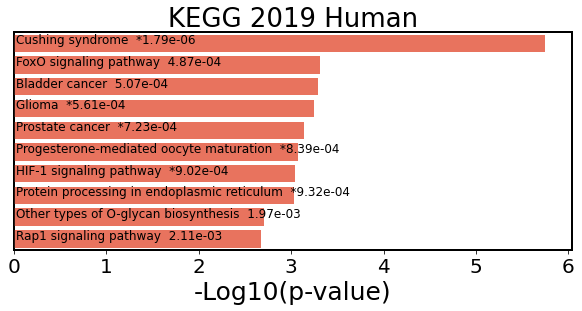

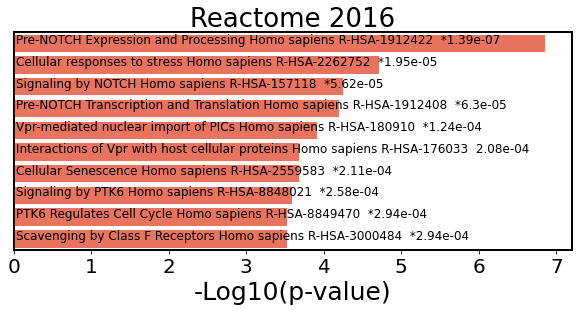

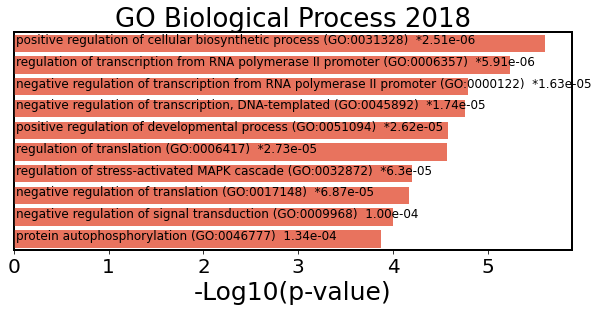

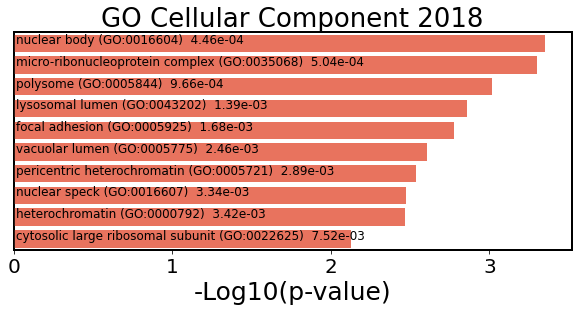

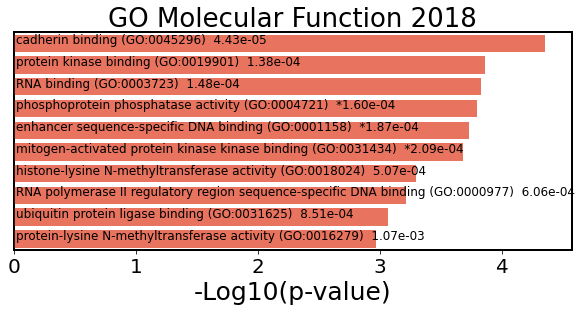

In [36]:
for i in enrichment_libraries:
    results = enrich(i, user_list_id, short_id)
    final_output_file_names = ["%s.png"%i]
    enrichr_figure(results[0],results[1],results[2],final_output_file_names, [i],"png", "tomato")

In [37]:
display(Markdown('Access your complete Enrichment results [here](%s)'% str('https://amp.pharm.mssm.edu/Enrichr/enrich?dataset='+ short_id)))

Access your complete Enrichment results here: https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=24e9ead05bf6c3cd4b8289bf16b92011

## References
[1] Wang, T., Xie, Y. and Xiao, G., 2014. dCLIP: a computational approach for comparative CLIP-seq analyses. Genome biology, 15(1), p.R11.

[2] Dale RK, Pedersen BS, and Quinlan AR. 2011. Pybedtools: a flexible Python library for manipulating genomic datasets and annotations. Bioinformatics 27(24):3423-3424.

[3] Quinlan AR and Hall IM, 2010. BEDTools: a flexible suite of utilities for comparing genomic features. Bioinformatics 26(6):841–842.

[4] Chen EY, Tan CM, Kou Y, Duan Q, Wang Z, Meirelles GV, Clark NR, Ma'ayan A. Enrichr: interactive and collaborative HTML5 gene list enrichment analysis tool. BMC Bioinformatics. 2013;128(14).

[5] Kuleshov MV, Jones MR, Rouillard AD, Fernandez NF, Duan Q, Wang Z, Koplev S, Jenkins SL, Jagodnik KM, Lachmann A, McDermott MG, Monteiro CD, Gundersen GW, Ma'ayan A. Enrichr: a comprehensive gene set enrichment analysis web server 2016 update. Nucleic Acids Research. 2016; gkw377 .